# Problema de regresión

In [3]:
import numpy as np
import pandas as pd
import helper
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist

In [4]:
(x_trainp, y_train) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("Data/train-morpho.csv")
test_morpho = pd.read_csv("Data/t10k-morpho.csv")
labels = pd.read_csv('Data/train_labels.csv')

In [5]:
train_morpho

,index,area,length,thickness,slant,width,height
0,0,107.3125,50.266504,2.460658,0.231074,14.539572,19.849054
1,1,123.2500,51.198485,2.616601,0.331858,15.387810,19.341053
2,2,78.3750,45.927670,1.891592,-0.212196,20.479656,19.114880
3,3,67.3125,22.849242,2.919769,0.509185,5.358179,19.724599
4,4,91.1875,46.284271,2.247425,0.007590,13.275437,19.527523
...,...,...,...,...,...,...,...
59995,59995,102.1875,61.415999,1.941380,0.366472,11.840672,19.937599
59996,59996,108.5625,46.705844,2.538071,0.364359,13.325950,19.688557
59997,59997,87.0625,44.523864,2.058077,0.257784,14.133500,20.070647
59998,59998,82.2500,53.337572,1.667193,0.310377,15.251961,19.692976


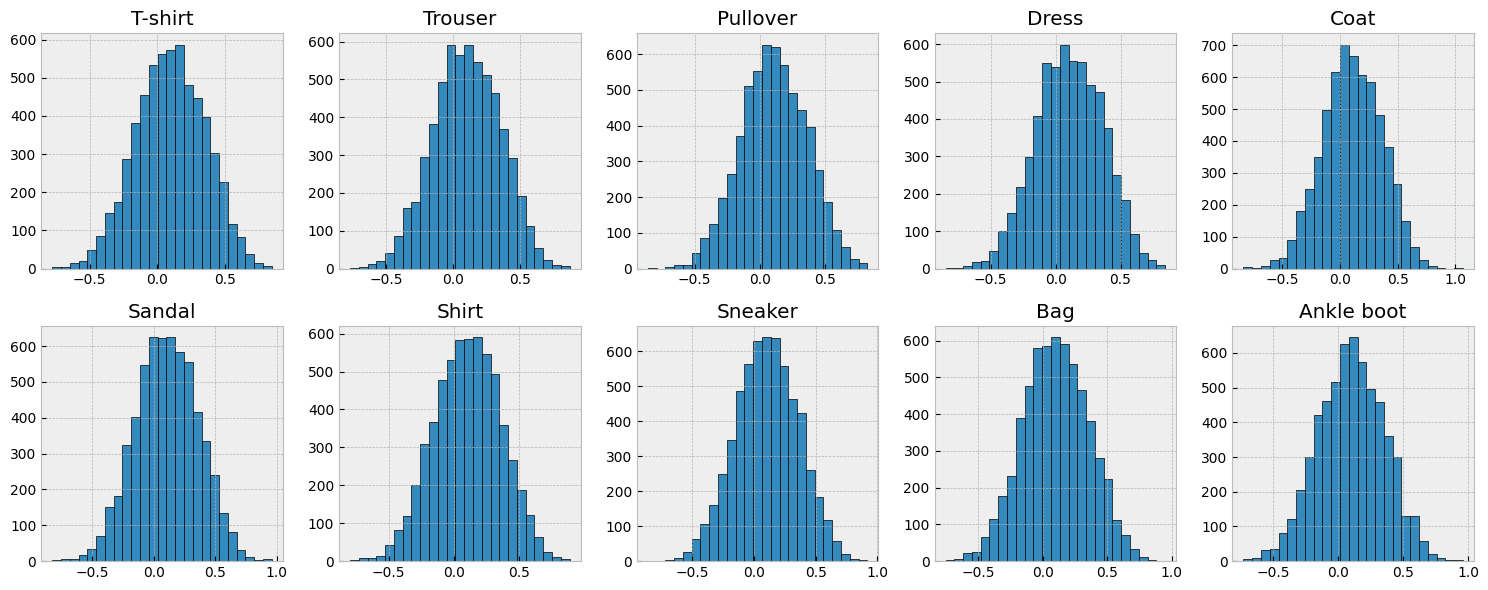

In [6]:
clases = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
helper.plotHistSlant(train_morpho, labels, clases)

In [7]:
slant = train_morpho['slant'].to_numpy()
slant

array([ 0.23107447,  0.33185821, -0.21219623, ...,  0.25778359,
        0.31037662,  0.58877155])

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_val, s_train, s_val = train_test_split(x_trainp, slant, test_size=0.25, random_state=42)
saltear, saltear2, y_train, y_val = train_test_split(x_trainp, y_train, test_size=0.25, random_state=42)

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Embedding, Concatenate, Input
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

In [10]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(784, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization(synchronized=True))
model.add(Dense(784/2, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization(synchronized=True))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 392)               307720    
                                                                 
 batch_normalization_1 (Batc  (None, 392)              1568      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [11]:
stp = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model.compile(loss='MAE', optimizer=Adamax(learning_rate=1, weight_decay=0.0005))
history = model.fit(x = x_train, y = s_train, validation_data = (x_val, s_val), epochs=40, batch_size=128, callbacks=[stp])

Epoch 1/40
352/352 [==============================] - 10s 24ms/step - loss: 33.7117 - val_loss: 0.5354
Epoch 2/40
352/352 [==============================] - 7s 21ms/step - loss: 0.3911 - val_loss: 0.3503
Epoch 3/40
352/352 [==============================] - 7s 21ms/step - loss: 0.2292 - val_loss: 0.2082
Epoch 4/40
352/352 [==============================] - 7s 21ms/step - loss: 0.2134 - val_loss: 0.1986
Epoch 5/40
352/352 [==============================] - 8s 22ms/step - loss: 0.2009 - val_loss: 0.2337
Epoch 6/40
352/352 [==============================] - 8s 21ms/step - loss: 0.2059 - val_loss: 0.2963
Epoch 7/40
352/352 [==============================] - 7s 21ms/step - loss: 0.3025 - val_loss: 0.7378
Epoch 8/40
352/352 [==============================] - 7s 21ms/step - loss: 0.4338 - val_loss: 0.2754


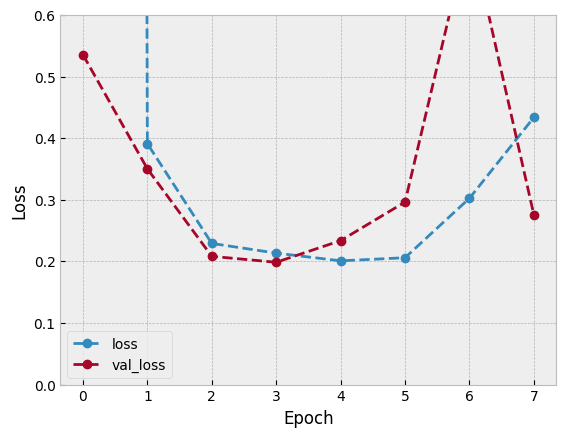

In [12]:
helper.plotLoss(history)

In [13]:
y = model.predict(x_val)

469/469 [==============================] - 2s 3ms/step


In [14]:
#for i in range(len(y)):
    #print(s_val[i], y[i])

In [15]:
input1 = Input(shape=(28, 28))

input2 = Input(shape=(1,))

first = Embedding(input_dim=10, output_dim=2, input_length=1)(input2)

flat1 = Flatten(input_shape=(1, 2))(first)

flat1 = Model(inputs=input2, outputs=flat1)

second = Flatten(input_shape=(28, 28))(input1)

second = Model(inputs=input1, outputs=second)

merged = Concatenate()([flat1.output, second.output])

act1 = Dense(786//2, activation='relu')(merged)

act2 = Dense(786//4, activation='relu')(act1)

output = Dense(1)(act2)

model2 = Model(inputs=[flat1.input, second.input], outputs=output)

model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 2)         20          ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 2)            0           ['embedding[0][0]']              
                                                                                            

In [16]:
stp = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model2.compile(loss='MAE', optimizer=Adam(learning_rate=0.001))
history2 = model2.fit(x = [y_train, x_train], y = s_train, validation_data = ([y_val, x_val], s_val), epochs=40, batch_size=32, callbacks=[stp])

Epoch 1/40
1407/1407 [==============================] - 11s 7ms/step - loss: 1.8612 - val_loss: 0.1253
Epoch 2/40
1407/1407 [==============================] - 10s 7ms/step - loss: 0.1166 - val_loss: 0.0663
Epoch 3/40
1407/1407 [==============================] - 10s 7ms/step - loss: 0.0701 - val_loss: 0.0523
Epoch 4/40
1407/1407 [==============================] - 10s 7ms/step - loss: 0.0643 - val_loss: 0.0890
Epoch 5/40
1407/1407 [==============================] - 10s 7ms/step - loss: 0.0601 - val_loss: 0.0612
Epoch 6/40
1407/1407 [==============================] - 10s 7ms/step - loss: 0.0502 - val_loss: 0.0443
Epoch 7/40
1407/1407 [==============================] - 10s 7ms/step - loss: 0.0490 - val_loss: 0.0629
Epoch 8/40
1407/1407 [==============================] - 10s 7ms/step - loss: 0.0463 - val_loss: 0.0443
Epoch 9/40
1407/1407 [==============================] - 10s 7ms/step - loss: 0.0465 - val_loss: 0.0422
Epoch 10/40
1407/1407 [==============================] - 10s 7ms/step - l

In [17]:
y2 = model2.predict([y_val, x_val])

469/469 [==============================] - 1s 2ms/step


In [18]:
#for i in range(len(y2)):
    #print(s_val[i], y2[i])

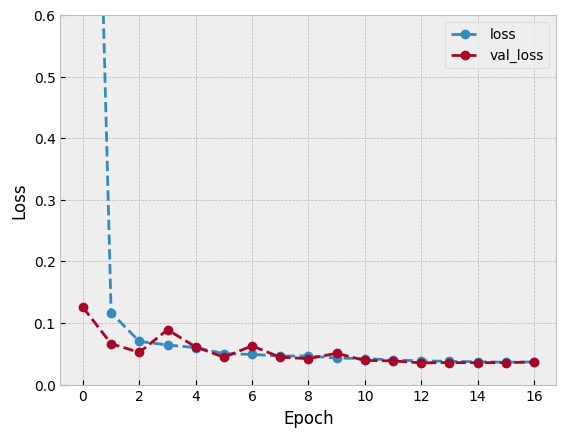

In [19]:
helper.plotLoss(history2)

In [20]:
emb = model2.get_weights()[0]

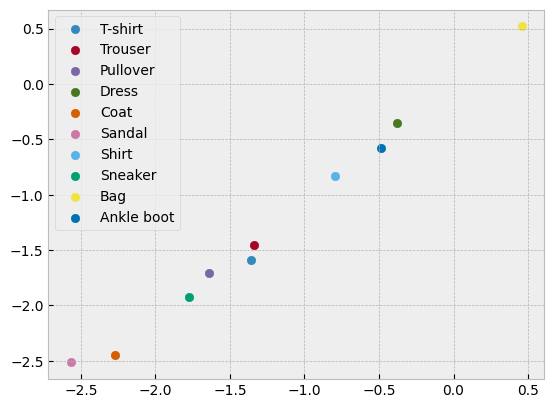

In [21]:
for idx, clase in enumerate(clases):
    plt.scatter(emb[idx, 0], emb[idx, 1], label=clase)
plt.legend()
plt.show()

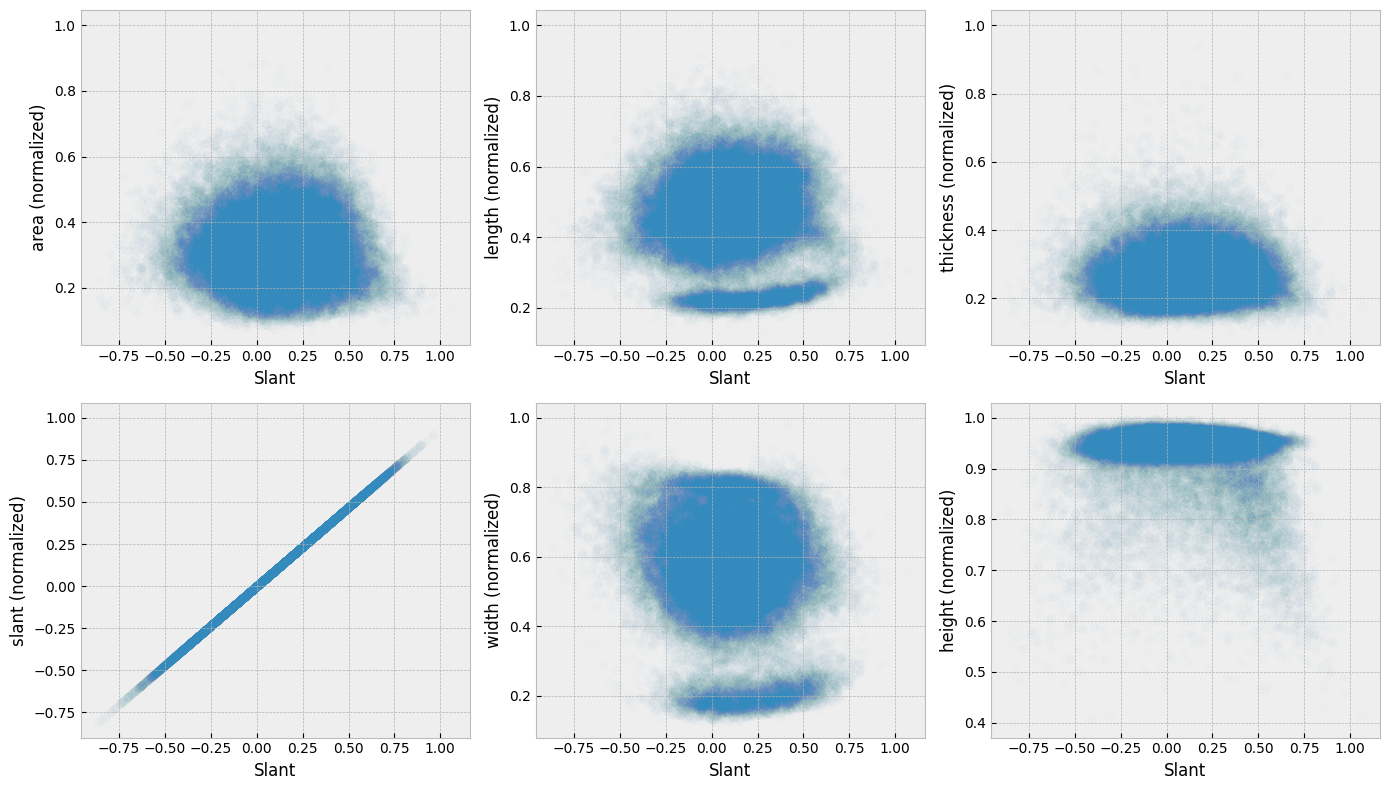

In [23]:
helper.plotScatters(train_morpho)

In [24]:
p3input1 = Input(shape=(28, 28))

p3input2 = Input(shape=(1,))

p3relu2 = Dense(1, activation='linear')(p3input2)

p3relu2 = Model(inputs=p3input2, outputs=p3relu2)

p3second = Flatten(input_shape=(28, 28))(p3input1)

p3second = Model(inputs=p3input1, outputs=p3second)

p3merged = Concatenate()([p3relu2.output, p3second.output])

p3act1 = Dense(786//2, activation='relu')(p3merged)

p3norm1 = BatchNormalization(synchronized=True)(p3act1)

p3act2 = Dense(786//4, activation='relu')(p3norm1)

p3norm2 = BatchNormalization(synchronized=True)(p3act2)

p3output = Dense(1)(p3norm2)

model3 = Model(inputs=[p3relu2.input, p3second.input], outputs=p3output)

model3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 1)            2           ['input_4[0][0]']                
                                                                                                  
 flatten_3 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                            

In [25]:
h = train_morpho['length'].to_numpy()
saltear, saltear2, h_train, h_val = train_test_split(x_trainp, h/max(h), test_size=0.25, random_state=42)

In [26]:
stp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model3.compile(loss='MAE', optimizer=Adam(learning_rate=0.001))
history3 = model3.fit(x = [h_train, x_train], y = s_train, validation_data = ([h_val, x_val], s_val), epochs=100, batch_size=32, callbacks=[stp])

Epoch 1/100
1407/1407 [==============================] - 16s 10ms/step - loss: 0.1482 - val_loss: 0.0715
Epoch 2/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0586 - val_loss: 0.0459
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0508 - val_loss: 0.0362
Epoch 4/100
1407/1407 [==============================] - 11s 8ms/step - loss: 0.0477 - val_loss: 0.0300
Epoch 5/100
1407/1407 [==============================] - 12s 8ms/step - loss: 0.0477 - val_loss: 0.0321
Epoch 6/100
1407/1407 [==============================] - 12s 8ms/step - loss: 0.0454 - val_loss: 0.0246
Epoch 7/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0445 - val_loss: 0.0205
Epoch 8/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0434 - val_loss: 0.0262
Epoch 9/100
1407/1407 [==============================] - 12s 8ms/step - loss: 0.0425 - val_loss: 0.0250
Epoch 10/100
1407/1407 [==============================] - 13s 9

In [27]:
y3 = model3.predict([h_val, x_val])

469/469 [==============================] - 1s 3ms/step


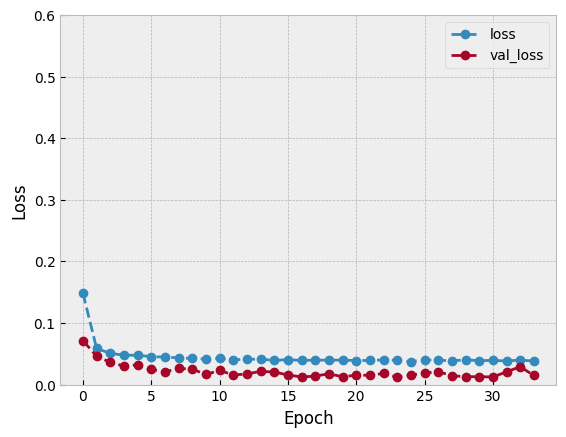

In [28]:
helper.plotLoss(history3)